# Model for mixed-dimensional flow

This notebook aims to introduce the basic concepts involved in running a simulation in PorePy, by investigating fluid flow in a fractured porous media. The notebook will cover
* A brief overview of the governing equations.
* An illustation of how to specify a domain with a fracture network and how to generate a mesh that conforms to the fractures.
* An overview of the ingredients needed to specify a full simulaiton in PorePy.
* An example of how to make simple modifications to the default model for fluid flow, and directions for further extensions.


## Problem statement: A mathematical model for fluid flow in fractured domains
Our problem consists of the following ingreidents:
1. A domain with some fractures embedded.
2. Equations which impose conservation of mass.
3. Constitutive laws for the relation between the fluid pressure and flux.


We will go through all these components in turn. The presentation will use some mathematical terminology without being overly technicaly.
This emphasis on mathematics reflects the philosophy underlying PorePy: Problems are stated in terms of equations, and this mathematical structure is reflected in discretization and implementation.
Thus, while it is possible to follow this notebook, and more generally to use PorePy, without reflecting much on the mathematical problem formulation, harnessing the full potential of the software requires a certain fluency in mathematics.

It should also be mentioned that the aim is to cover the important concepts and we may sometimes prioritize ease of presentation over precision in the arguments. More precise arguments can be found in the papers that describe the various parts of PorePy.

### Fracture network geometry
Let $\Omega_0$ be a regular domain with boundary $\partial \Omega_F$. 
In $\Omega_0$, we introduce a set of fractures, which we can denote as $\Omega_i^F$, where $i$ is a counter of the fractures. Crucially, we will consider fractures to be objects of dimension one less than the host domain, so, for a 2d domain, a fracture is 1d. 
Moreover, we will assume that all fractures are straight lines (in 2d domains) and planar (in 3d domains). For 2d domains, this means we can describe a fracture by its start- and endpoint.


We will also need a description of the boundary of $\Omega_0$. This will in part consist of the external boundary, which can be divided in two non-overlapping parts on which we will impose Dirichlet ($\partial \Omega_0^d$) and Neumann ($\partial \Omega_0^n$) boundary conditions, respectively.
More interesting is the boundary of $\Omega_0$ towards the fractures $\Omega_i^F$, which we will represent by $\partial\Omega_i^F$, and occasionally write $\partial^{\pm}\Omega_i^F$ to denote the two sides of the fracture.

For simplicity, we have not included notation to describe intersection between two fractures. 

### Conservation equations
Assuming the fluid is incompressible, we have from basic continuum mechanics that conservation of mass for a domain $\Omega$ is described by the equation

$$ \nabla \cdot \mathbf{q} = f, \,\,in\,\, \Omega$$

Here, $\mathbf{q}$ is the fluid flux and $f$ represents source terms. 
In addition comes boundary conditions, on the form 
$$\mathbf{q}\cdot\mathbf{n} = q_N, \,\,on\,\, \partial\Omega^N, \qquad p=p_D \,\,on\,\, \partial\Omega^D$$
of Neumann and Dirichlet type, respectively, where we have introduced the fluid pressure $p$.

To make this general equation fit with a fractured media, we first introduce the flux $\lambda_i^{\pm}$ between $\Omega_0$ and a fracture $\Omega_i^F$. For $\Omega_0$ the interface to the fracture takes the form of a standard boundary, and $\lambda_i^{\pm}$ enters as an additional Neumann boundary condition, $\mathbf{q}\cdot\mathbf{n} = \lambda_i^{\pm},  \,\,on\,\, \partial_i^{pm}\Omega_0$ ($\mathbf{n}$ is here the outer normal vector), thus $\lambda_i$ is positive for flow from $\Omega_0$ to $\Omega_i^F$).
The fracture $\Omega_i^F$ has no proper boundary towards $\Omega_0$ (recall that $\partial_i^{pm}\Omega_0$ has the same dimension as $\Omega_i^F$). Flow from $\Omega_0$ to $\Omega_i^F$ instead manifests as a source term, and conservation of mass is expressed as 

$$ \nabla \cdot \mathbf{q}_i - (\lambda_i^+ + \lambda_i^-) = f, \,\,in\,\, \Omega_i^F.$$


### Constitutive laws
To close the model, we need constitutive laws for the fluxes $\mathbf{q}_0$, $\mathbf{q}_i \,\, (i>0)$ and $\lambda_i^{\pm}$.
In $\Omega_0$ we apply Darcy's law and write 
$$\mathbf{q}_0 = \mathbf{K}_0\nabla p_0$$
In $\Omega_i^F$ we will assign the permeability according to the so-called cubic law, and set

$$\mathbf{q}_i = \mathbf{K}_i , \qquad K_i=\frac{a^3}{12}, \qquad i=\{1, 2, ...\}$$

where $a$ is the fracture aperture. 

Finally, the flux $\lambda$ is related to the pressure on the two surrounding sides by

$$\lambda_i = \kappa(p_0 - p_i),  \qquad i=\{1, 2, ...\} $$

Here, the parameter $\kappa$ can be considered the permeability of the fracture in its normal direction.

This definition follows the convention in PorePy that an interface flux is positive if it goes from the higher- to the lower-dimensional domain.

### Extension to fracture intersections
The above framework can readily be extended to domains where fractures intersect to form domains of dimension $nd-2$ and, in 3d, intersections of intersection lines (e.g., points that have dimension $nd-3).
The intersections will form separate subdomains with their own pressures and fluxes (unless the subdomain is a point) and there will be fluxes between the fractures and fracture intersections.
This is all implemented in PorePy, but we do not explicitly spell out the formulation here, since it requires quite a bit of notation to do things correctly.


# Implementation
To see how this works in practice, we will set up a PorePy simulation of fluid flow in a fractured domain. The first thing we do is to import PorePy. At the same time, we will also import numpy, which is used to define arrays of various types.


In [11]:
import porepy as pp
import numpy as np

## Define the geometry
We first need a domain with some fractures. This is done in three steps: 
1. Specify the geometry of the domain, represented by an object of the class `pp.Domain`.
2. Define all fractures to be included. In a 2d domain, the fractures are lines represented by the class `pp.LineFracture`.
3. Gather domain and fracutres into a fracture network, represented by the `pp.FractureNetwork2d` class.

In [12]:
# Define the domain. The easiest option here is to set a box-shaped domain, specified by its min and max coordinates.
domain = pp.Domain({'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1})

# A line fracture is defined by its endpoints, specified in the form of a numpy list.append
# The first row defines the x-coordinates, the second the y-coordinates, so this fracture
# runs from (0.3, 0.4) to (0.7, 0.6).
frac_1 = pp.LineFracture(np.array([[0.3, 0.7], [0.4, 0.6]]))

# We can define a second fracture. This will cross the first one in (0.5, 0.5)
frac_2 = pp.LineFracture(np.array([[0.4, 0.6], [0.3, 0.7]]))

# Add a third fracture which extends outside the domain
frac_3 = pp.LineFracture(np.array([[0.8, 1.2], [0.8, 1.2]]))

# Collect all fractures in a list
fracture_set = [frac_1, frac_2, frac_3]

# Define the fracture network.
network = pp.FractureNetwork2d(fracture_set, domain=domain)



## Mesh generation
Meshing in PorePy is outsourced to the mesh generator [Gmsh](http://gmsh.info/). To use this functionality, we will invoke the `mesh` method in the fracture network class. While Gmsh allows for sophisticated control of the mesh sizes, only a small part of this functionality is exposed in PorePy. Specifically, three parameters should be set: `mesh_size_bound`, `mesh_size_frac`, and `mesh_size_min` (the latter is not always necessary, but we will include it). The first two sets the preferred mesh size on the domain boundary and on the fractures, respectively, while the third attempts to limit the smallest cells being made. Gmsh will in many cases obey these instructions, but if the geometry requires finer cells to be properly meshed, the instructions will not be faithfully followed.

In [13]:
# To construct a grid, we can write
mdg = network.mesh(mesh_args={'mesh_size_min': 0.03, 'mesh_size_bound': 0.2, 'mesh_size_frac':0.1})

The meshing returns a mixed-dimensional grid (an object of class `pp.MixedDimensionalGrid`), which is composed of subdomains for the $\Omega_0$, the fractures and the intersections. In addition, there are interfaces between the grids. We can get some information on the grids by writing

In [14]:
print(mdg)

Mixed-dimensional grid. 
Maximum dimension present: 2 
Minimum dimension present: 0 
Size of highest dimensional grid: Cells: 182. Nodes: 115
In lower dimensions: 
3 grids of dimension 1, with in total 14 cells and 19 nodes. 
1 grids of dimension 0, with in total 1 cells and 0 nodes. 
Total number of interfaces: 5
3 interfaces between grids of dimension 2 and 1 with in total 28 cells
2 interfaces between grids of dimension 1 and 0 with in total 4 cells



The recommended way of visualizing results is to export the data to paraview, more on that later. However, crude 2d visualization can also be made directly in Python:

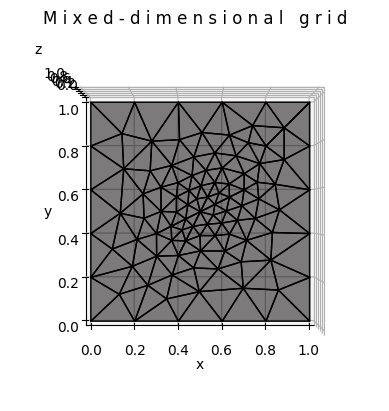

In [15]:
# The alpha parameter is passed to matplotlib, and ensure that the cells are semi-transparent (thus the plot possible to interpret)
pp.plot_grid(mdg, alpha=0.5)

## Setting up a flow problem
Having seen how to define a geometry and construct a mesh, we turn to setting up the flow problem itself. PorePy comes equipped with templates for setting up several types of problems, hereunder the flow problem. These templates are designed to facilitate modification of the problems such as modifying parameters or even change or add terms the equations. This flexibility is achieved by invoking programing techniques (specifically a special type of inheritance known as mixins) that are powerful, but also prone to errors if not used correctly. We will point out some critical points below, but it is strongly recommended to read up on Python mixins before starting to use this in earnest.

The standard setup for flow problems is available as `pp.fluid_mass_balance.SinglePhaseFlow()`. We can run this right away:

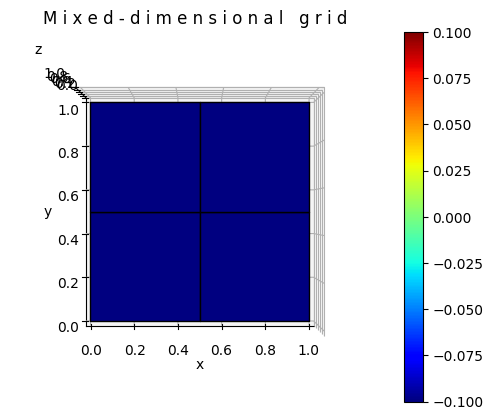

[0. 0. 0. 0.]


In [16]:
# Create a model object, using the template
model = pp.fluid_mass_balance.SinglePhaseFlow()

# Run the problem as time dependent (the model allows for a compressible fluid, which
# will add a time derivative term). The params dictionary can be used to pass arguments
# to the solution method, but we can safely leave that empty.
pp.run_time_dependent_model(model, params={})

# Plot the computed pressure
pp.plot_grid(model.mdg, 'pressure')

# We can also access the computed pressure values: First, get hold of the grid used in
# the model (note that this line overwrites the grid we created above)
mdg = model.mdg
# We can access individual subdomain grids, filtered on dimensions
sd_2d = mdg.subdomains(dim=2)[0]
# The mixed-dimensional grid also stores information relating to the grids:
data_2d = mdg.subdomain_data(sd_2d)
# The pressure is available at
pressure = data_2d[pp.STATE]['pressure']
print(pressure)


We see that, while we have computed a pressure solution, it is not very interesting (as a side remark, if the plot of the pressure rendered the solution to something else than 0, this should be seen as an illustration that the native plotting routine in PorePy are not always reliable, use Paraview instead). Moreover, the geometry is not the fracture network we defined before. 

The first modification we do is to reintroduce the fracture network. To that end, we will basically use the same code as we did previously, but we need to wrap it in the right format for it to be compatible with the `SinglePhaseFlow` class in the following way:

In [17]:
class GeometryWithFractures(pp.ModelGeometry):
    # We need to make a class which inherits from the class pp.ModelGeometry (if you don't
    # know what inheritance means, you just have to accept this for now, but do google
    # inheritance in object oriented programing at some point).

    def set_fracture_network(self):
        # The class pp.ModelGeometry has several useful methods that we will leave
        # unaltered, but we do need to change the method which specifies the geometry.
        #
        # The code below is copied from above, except from a crucial modification in the
        # last line.
        #
        # PorePy has a built-in system to change units (for instance, measure
        # distance in milimeters rather than meters) and make sure this is done
        # consistently throughout the equations in a model. This typically requires
        # some boilerplate, like the one we use below. Strictly speaking, it is not
        # needed here, since our domain is of unit size, but it is good pracice to get
        # used to this anyhow.
        length_scaling = 1 / self.units.m

        # Define the domain. The easiest option here is to set a box-shaped domain,
        # specified by its min and max coordinates.
        domain = pp.Domain({'xmin': 0,
                            'xmax': 1 * length_scaling,
                            'ymin': 0,
                            'ymax': 1 * length_scaling
                            })

        # A line fracture is defined by its endpoints, specified in the form of a numpy list.append
        # The first row defines the x-coordinates, the second the y-coordinates, so this fracture
        # runs from (0.3, 0.4) to (0.7, 0.6).
        frac_1 = pp.LineFracture(np.array([[0.3, 0.7], [0.4, 0.6]]) * length_scaling)

        # We can define a second fracture. This will cross the first one in (0.5, 0.5)
        frac_2 = pp.LineFracture(np.array([[0.4, 0.6], [0.3, 0.7]]) * length_scaling,)

        # Add a third fracture which extends outside the domain
        frac_3 = pp.LineFracture(np.array([[0.8, 1.2], [0.8, 1.2]]) * length_scaling,)

        # Collect all fractures in a list
        fracture_set = [frac_1, frac_2, frac_3]

        # Define the fracture network, and assign it to the attribute
        # self.fracture_network
        self.fracture_network = pp.FractureNetwork2d(fracture_set, domain=domain)

    def mesh_arguments(self) -> dict:
        # We also need to set the mesh size arguments. These are also scaled with length
        length_scaling = 1 / self.units.m
        return {'mesh_size_min': 0.03 * length_scaling,
                'mesh_size_bound': 0.2 * length_scaling,
                'mesh_size_frac': 0.1 * length_scaling
                }

Now, we can define a new model class which incorporates our geometry, define a new model for flow, solve it and plot the results.

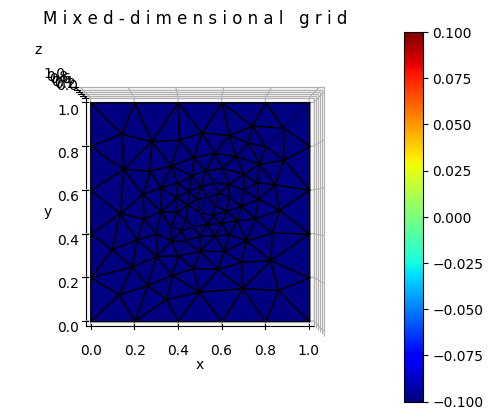

In [18]:
class SinglePhaseFlowWithFractures(GeometryWithFractures, pp.fluid_mass_balance.SinglePhaseFlow):
    # Define a new model class which inherits both from our geometry class and the template.
    # In practice, this will make a model which picks those methods that we defined in
    # GeometryWithFractures, but leave all other methods unaltered from the template.
    pass

# Create an object of our now class
model_with_fractures = SinglePhaseFlowWithFractures()
# Run it in the same way as before
pp.run_time_dependent_model(model_with_fractures, params={})
# Plot the result
pp.plot_grid(model_with_fractures.mdg, 'pressure')

We managed to introduce our fracture network. Note that precision in coding is critical, what happens if we misspell the method name `GeometryWithFractures.set_fracture_network()`, or make a typo in the assignment  `self.fracture_network` in that function?

To produce a non-trivial pressure solution, we will change the boundary conditions. By default, zero pressure conditions are assigned on all boundary conditions, but will instead set no-flow conditions on the top and bottom, and a unit pressure on the left boundary. To that end, we need to create a new class that modifies the standard setup of boundary conditions for single phase flow.


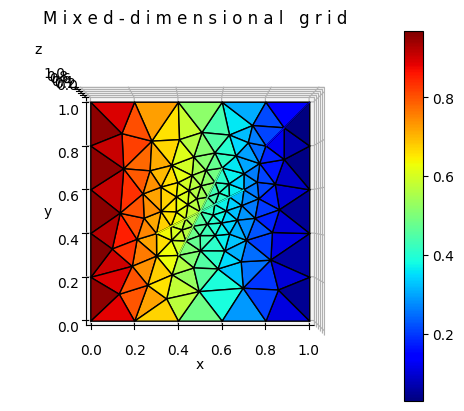

In [19]:
class ModifiedBoundaryConditions(pp.fluid_mass_balance.BoundaryConditionsSinglePhaseFlow):
    # We need to modify two methods from the template: One which sets the type of boundary
    # conditions, and the other which sets values.

    def bc_type_darcy(self, sd: pp.Grid) -> pp.BoundaryCondition:
        # Boundary conditions are set on the faces on the subdomain grid. We can get
        # hold of sets of boundary faces by usign a special object:
        domain_boundary = self.domain_boundary_sides(sd)
        # By default, flow problems are set up with Neumann conditions. Thus we only need
        # to change the conditions on hte left and right faces.
        # The left and right boundaries are accessible as
        left_faces = domain_boundary.west
        # And the right faces as
        right_faces = domain_boundary.east
        # Set Dirichlet conditions on the left and right boundary faces.
        bc = pp.BoundaryCondition(sd, left_faces + right_faces, 'dir')
        return bc

    def bc_values_darcy(self, subdomains: list[pp.Grid]) -> pp.ad.AdArray:
        # The default boundary condition value is 0, thus we only need to change the
        # value for the left boundary. However, note that the signature of this method
        # is different from the one setting the type of boundary conditions: Instead of
        # sending in the grid for a single subdomain, we send in a list (in practice, this
        # list may contain all subdomains in our problem, that is, the 2d domain, all
        # fractures and the intersection grid).
        #
        # One more point to note is the return type, indicated by '-> pp.ad.Array':
        # Equations in PorePy are defined using a technique called automatic differentiation
        # (ad). This allows us to set up complex non-linear problems and solve them with
        # Newton's method without having to worry too much about how to differentiate
        # the residual equations. This is not important to us at this point, but we will
        # have to make sure that we return an object of the expected size.

        if len(subdomains) == 0:
            # This will not happen in our case, but we include it for illustrative
            # purposes.
            return pp.ad.AdArray(np.zeros(0), name="bc_values_darcy")

        # Storer of the boundary condition values for all subdomains
        bc_val_glob = []
        for sd in subdomains:
            # Iterate over all the subdomains are passed. If it has faces on the left
            # part of the domain, we will assign a unit value there. If not, set zero
            # values.
            # If the subdomain does not touch the left side of hte boundary, left_faces
            # will be empty.
            left_faces = self.domain_boundary_sides(sd).west
            bc_values_loc = np.zeros(sd.num_faces)
            # The boundary condition must also be scaled according to its units.
            bc_values_loc[left_faces] = self.fluid.convert_units(1, "Pa")
            # Add this subdomain to the global values
            bc_val_glob.append(bc_values_loc)

        # Having looped over all the subdomains, what remains is to wrap the boundary
        # values in the Ad format:
        wrapped_bc_values = pp.wrap_as_ad_array(np.hstack(bc_val_glob), name="bc_values_darcy")
        return wrapped_bc_values


# Define a model class which extends the template with both our geometry and boundary condition
class FlowWithFracturesAndBc(GeometryWithFractures, ModifiedBoundaryConditions, pp.fluid_mass_balance.SinglePhaseFlow):
    pass

model_bc_fractures = FlowWithFracturesAndBc()
pp.run_time_dependent_model(model_bc_fractures, {})

pp.plot_grid(model_bc_fractures.mdg, 'pressure')


Now we are getting somewhere. As a final step, we will also modify the fracture permeability. Looking back at the constitutive law for fracture permeability, we understand this will get a bit complicated: The fracture permeability is (essentially) split in two parts: The tangential component which we denoted $K_i^F$ and the normal component which gives the permeability between fracture and matrix and which we denoted $\kappa_i$. PorePy has ways of setting each of these, but we have to do so in the right way:

Considering first the tangential component, we modeled this as a function of the fracture aperture. This can be modified by manipulating the class `pp.constitutive_laws.DimensionReduction`, as is done below. Be aware that this class actually has two aperture-related methods: We will work with the method `grid_aperture()` which can be used to set the aperture in individual grids (or even individual cells within thi grid). There is also a method which is simply called `aperture()`, which is used in more advanced models where the fracture aperture changes, for instance due to mechanical deformation.

To modify the fracture aperture, we do

In [20]:
class ModifiedAperture(pp.constitutive_laws.DimensionReduction):
    def grid_aperture(self, grid: pp.Grid) -> np.ndarray:
        # Set a unit aperture by default. The aperture will not be used for the 2d grid,
        # but it is still good practice to return values that have the minimal chance of
        # doing harm.
        aperture = self.solid.convert_units(1, 'm') * np.ones(grid.num_cells)
        if grid.dim < self.nd:
            # We can get the dimension of a grid like this. Self.nd gives the dimension
            # of the full geometry, in this case 2, thus this 'if' is active for line
            # and point grids.
            # Set the fracture aperture to 1mm
            aperture *= 1e-2
        return aperture

Next, we need to translate this aperture into a fracture permeability, which we do by invoking `pp.constitutive_laws.CubicLawPermeability`. Moreover, we should also stop to think whether an aperture of 1mm will impact the flow. The answer is, it depends on the 2d permeability, an aperture of $1e-3$ will give a fracture aperture of roughly $1e-10$, so unless the 2d permeability is significantly lower, fractures will not matter. We will therefore also change 2d permeability, and can do this in the same file:

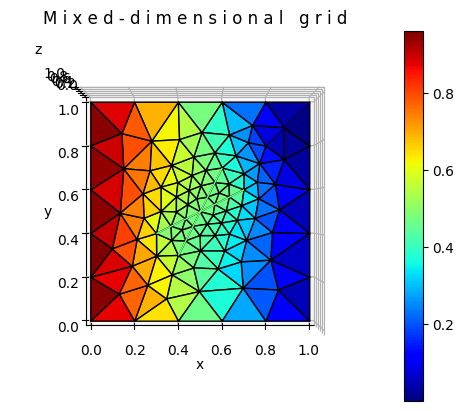

In [21]:
class CubicLawLowMatrixPermeability(pp.constitutive_laws.CubicLawPermeability):
    # We use the CubicLawPermeability class to set the permeabilities. If we combine
    # this class with the ModifiedAperture class we made above, the grid_aperture method
    # we just made will be used to define fracture permeability (this is functionality
    # that is already in the template CubicLawPermeability class). What remains for us
    # is to set the matrix permeability, and to have a look at how the normal permeability
    # (\kappa_i) is set.

    def matrix_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        # Asign a unit 
        size = sum(sd.num_cells for sd in subdomains)
        # Again we need to wrap the numerical value in the ad framework.
        permeability = pp.wrap_as_ad_array(
            self.solid.convert_units(1e-12, 'm^2'), size=size, name="permeability"
        )
        return permeability

    def normal_permeability(self, interfaces: list[pp.MortarGrid]) -> pp.ad.Operator:
        # For the normal permeability, the first thing to note is that the input is not
        # a lits of subdomains, but of interfaces (that is, mortar grids that reside
        # between the fracture and the matrix, and also between fractures and fracture
        # intersections).
        # One can do various types of modeling here, or at least try to relate the normal
        # permeability to an idea of an equi-dimensional permeability for the fracture.
        # We instead just assign a value, and scale it.
        normal_perm = pp.ad.Scalar(self.solid.convert_units(1e-1, 'm^2'))
        return normal_perm
        


# Now we can define the final model class
class ModelWithFractureBCandCubicLaw(GeometryWithFractures,
                                     ModifiedBoundaryConditions,
                                     ModifiedAperture,
                                     CubicLawLowMatrixPermeability,
                                     pp.fluid_mass_balance.SinglePhaseFlow):
    pass


# Create object of the model class and solve
final_model = ModelWithFractureBCandCubicLaw()
pp.run_time_dependent_model(final_model, params={})
pp.plot_grid(final_model.mdg, 'pressure')


A comparison with the results obtained with default values for permeabilities show that the fractures significantly change the pressure field.

## What next?
The framework we have employed undeniably is complex, it took a significant number of lines of code to solve what is really a simple problem, and even more lines of comments to give some idea of what is going on. The power of the framework lies in its ability to solve much more complex problems that can be set up with the same types of steps. To solve a problem with 100s of fractures, the method `set_fracture_network()` would need to change, but the rest of the code stays the same. To add compressibility effects, we should let the model inerit from `pp.constitutive_laws.FluidDensityFromPressure`.

In addition to simple mass balance, PorePy ships with several other template setups, including coupled flow and energy transport, and mechanical deformation of rock and fractures under a range of physical forces. These templates can be adapted using steps analogue to those we used above.

# Exercises

1. Modify the fracture geometry to make the fracture network a more prominent pathway for fluid flow.
2. Drive the flow using a Neumann rather than a Dirichlet condition.
3. Introduce a new fracture, running from $(0.2, 0)$ to $(0.2, 0.9)$. Assign a low tangential and/or normal permeability and see how this impacts the flow.
4. Make the flow go from the top to the bottom of the domain instead of left to right? Hint: The relevant domain boundaries are referred to as `north` and `south`.
